# Test d'un modèle LENET

Tensorflow ne fonctionne pas avec python 3.12 pour les GPU. J'ai donc installé un manager de version python, pyenv, pour passer à la version 3.11.3 de python pour le faire fonctionner.

Malheuresement, cela ne fonctionne plus avec windows : il faut installer WSL, qui permet d'utiliser Linux sur Windows. La manip est fastidieuse, donc pour l'instant on se contentera 
du CPU.

J'ai choisi de tester le modèle sur les images normalisées, en essayant de les classifier selon les 3 catégories COVID, Non-COVID, et Normal.

On commence par importer les modules :

In [20]:
#----------------------------------------------------------------------------#

import numpy as np
import tensorflow as tf
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import Dataset, random_split, Subset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.model_selection import train_test_split

#----------------------------------------------------------------------------#

## Séparations des images en set de train, validation et test

In [17]:
#----------------------------------------------------------------------------#

# Chemin du dossier principal (ne pas oublier de copier les images car la transformation est permanente)
main_dir = r'C:\Users\Nicolas\Documents\DataScience\MAR24_BDS_Radios_Pulmonaire\data\processed\test NB\LENET_processing'

# Sous dossiers et labels correspondants
folders = {
    'COVID_norm': 0,
    'Non-COVID_norm': 1,
    'Normal_norm': 2
}

# On récupère les images et leurs labels
image_paths = []
image_labels = []

for folder, label in folders.items():
    folder_path = os.path.join(main_dir, folder)
    for img in os.listdir(folder_path):
        if img.endswith(('.png', '.jpg', '.jpeg')):  
            image_paths.append(os.path.join(folder_path, img))
            image_labels.append(label)

# Splitting data into train+validation and test sets
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, random_state=42, stratify=image_labels)

# Splitting train+validation into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.176, random_state=42, stratify=train_val_labels)

#----------------------------------------------------------------------------#

## On va maintenant creer le dataset et le dataloader dans Pytorch

In [ ]:
#----------------------------------------------------------------------------#

## Sous classes permettant d'obtenir les images et leurs labels

class XRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('L')  # On convertit en niveau de gris
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

# On transforme les données en 32x32 pour que cela convienne à LENET
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),        
])

# On crée les datasets
train_dataset = XRayDataset(train_paths, train_labels, transform=transform)
val_dataset = XRayDataset(val_paths, val_labels, transform=transform)
test_dataset = XRayDataset(test_paths, test_labels, transform=transform)

# On crée les dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#----------------------------------------------------------------------------#


#### Avec cette méthode et Pytorch, le resizing est obligatoire.

## On définit le modèle LENET

In [6]:
#----------------------------------------------------------------------------#

## On instancie un modèle de classe LENET

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, 5),          # (N, 1, 32, 32) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400, 120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Linear(120, 84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84, 3)             # (N, 84) -> (N, 3)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

#----------------------------------------------------------------------------#

## On entraîne le modèle sur le set train

In [ ]:
#----------------------------------------------------------------------------#

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## On vérifie si l'on peut utiliser la carte graphique
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # Boucle sur le dataset
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print tous les 200 mini batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Fin Entrainement')

#----------------------------------------------------------------------------#

## Maintenant que le modèle est entraîner, nous pouvons visualiser sa performance sur ce set 

Confusion Matrix:
[[1386  160  247]
 [ 180 1351  159]
 [ 161  152 1292]]
Classification Report:
              precision    recall  f1-score   support

       COVID       0.80      0.77      0.79      1793
   Non-COVID       0.81      0.80      0.81      1690
      Normal       0.76      0.80      0.78      1605

    accuracy                           0.79      5088
   macro avg       0.79      0.79      0.79      5088
weighted avg       0.79      0.79      0.79      5088



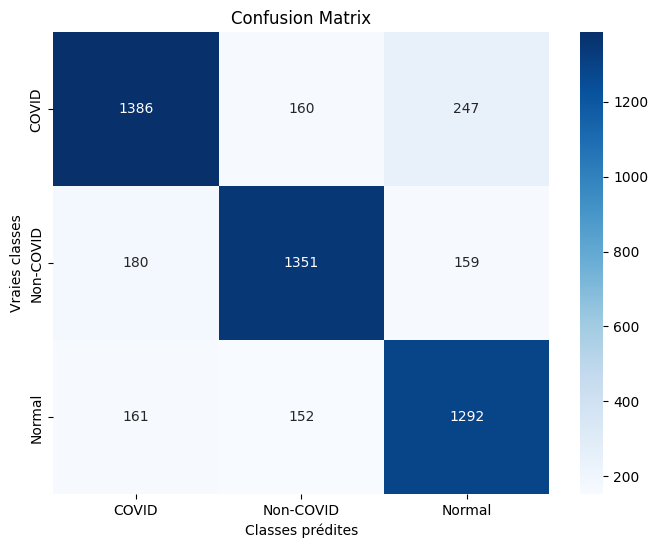

In [32]:
#----------------------------------------------------------------------------#

## On évalue le modèle sur le set de test avec la matrice de confusion et le classification report

def evaluate_model(model, data_loader, device):
    model.eval()  # On met le modèle en mode évaluation
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # On calcule la matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    
    # On affiche le rapport de classification
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['COVID', 'Non-COVID', 'Normal']))

    # On plot la matrice de confusion
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['COVID', 'Non-COVID', 'Normal'], yticklabels=['COVID', 'Non-COVID', 'Normal'])
    plt.xlabel('Classes prédites')
    plt.ylabel('Vraies classes')
    plt.title('Confusion Matrix')
    plt.show()


evaluate_model(model, test_loader, device)

#----------------------------------------------------------------------------#